In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

In [2]:
from brewaed import utils, labels, beerbubble
import brewaed


In [3]:

import os
import math

import numpy
import pandas

import librosa
import soundfile

from matplotlib import pyplot as plt
import librosa.display

In [4]:
def load_dataset(path):
    df = pandas.read_csv(path)
    df = df.set_index('id')
    
    return df

data_dir = '../data'
files_path = os.path.join(data_dir, 'files.csv')

files = load_dataset(files_path)
files['path'] = os.path.join(data_dir, 'audio') + os.path.sep + files.filename 
files

,youtube_url,filename,brews,path
id,,,,
MN0Mg1uyznU,https://www.youtube.com/watch?v=MN0Mg1uyznU,ASMR _ Homebrewing Airlock Symphony 🍺🎼 Soothin...,3,../data/audio/ASMR _ Homebrewing Airlock Symph...
by0e-EkAsOE,https://www.youtube.com/watch?v=by0e-EkAsOE,One hour of apple wine airlock bubbling-by0e-E...,1,../data/audio/One hour of apple wine airlock b...
q2srYoC3FOo,https://www.youtube.com/watch?v=q2srYoC3FOo,Bubbling airlock on pear cider-q2srYoC3FOo.m4a,1,../data/audio/Bubbling airlock on pear cider-q...
p0jtxp5nWms,https://www.youtube.com/watch?v=p0jtxp5nWms,Watch an Airlock Bubbling During Mead Fermenta...,1,../data/audio/Watch an Airlock Bubbling During...
f3bLQLT48Yc,https://www.youtube.com/watch?v=f3bLQLT48Yc,Ginger beer brewing day nine-f3bLQLT48Yc.m4a,1,../data/audio/Ginger beer brewing day nine-f3b...
WHlSNkq29k4,https://www.youtube.com/watch?v=WHlSNkq29k4,Airlock during fermentation.-WHlSNkq29k4.m4a,1,../data/audio/Airlock during fermentation.-WHl...
51ytpDZj8v4,https://www.youtube.com/watch?v=51ytpDZj8v4,Elderflower Airlock-51ytpDZj8v4.m4a,1,../data/audio/Elderflower Airlock-51ytpDZj8v4.m4a
gQFo3Lg2MAc,https://www.youtube.com/watch?v=gQFo3Lg2MAc,Airlock bubbler_Home brewing-gQFo3Lg2MAc.m4a,1,../data/audio/Airlock bubbler_Home brewing-gQF...
po2u_qI7-us,https://www.youtube.com/watch?v=po2u_qI7-us,S-Style Beer_Wine Air Lock Bubbling-po2u_qI7-u...,1,../data/audio/S-Style Beer_Wine Air Lock Bubbl...


In [5]:

def load_file(path, sr=16000):
    y, sr = librosa.load(path, offset=0, duration=5*60, sr=sr)
    
    return y
    
audio = load_file(files.iloc[0].path)

/home/jon/.local/lib/python3.9/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [6]:

def plot_time_spans(ax, spans, **kwargs):
    
    # TODO: support adding text
    for idx, span in spans.iterrows():
        s = span.start
        e = span.end
        #print(s, e)
        ax.axvspan(xmin=s, xmax=e, **kwargs)

    return None

def find_events(data, n_mixtures = 2, random_state = 1, n_states = 2):

    import hmmlearn.hmm
    
    import sklearn.pipeline
    from sklearn.preprocessing import StandardScaler

    model = hmmlearn.hmm.GMMHMM(n_components=n_states, n_mix=n_mixtures,
                            covariance_type="diag", random_state=random_state,
    )

    X = StandardScaler().fit_transform(data)
    model.fit(X)
    prob = model.score_samples(X)[1][:,1]
    
    out = pandas.DataFrame({
        'prob': prob,
    })
    return out


po2u_qI7-us


/home/jon/.local/lib/python3.9/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/jon/.local/lib/python3.9/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jon/.local/lib/python3.9/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/jon/.local/lib/python3.9/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases

Event distances: 3.7760000000000002 0.02396972139615401
Events expected 2
Events gotten 3 150.0 %


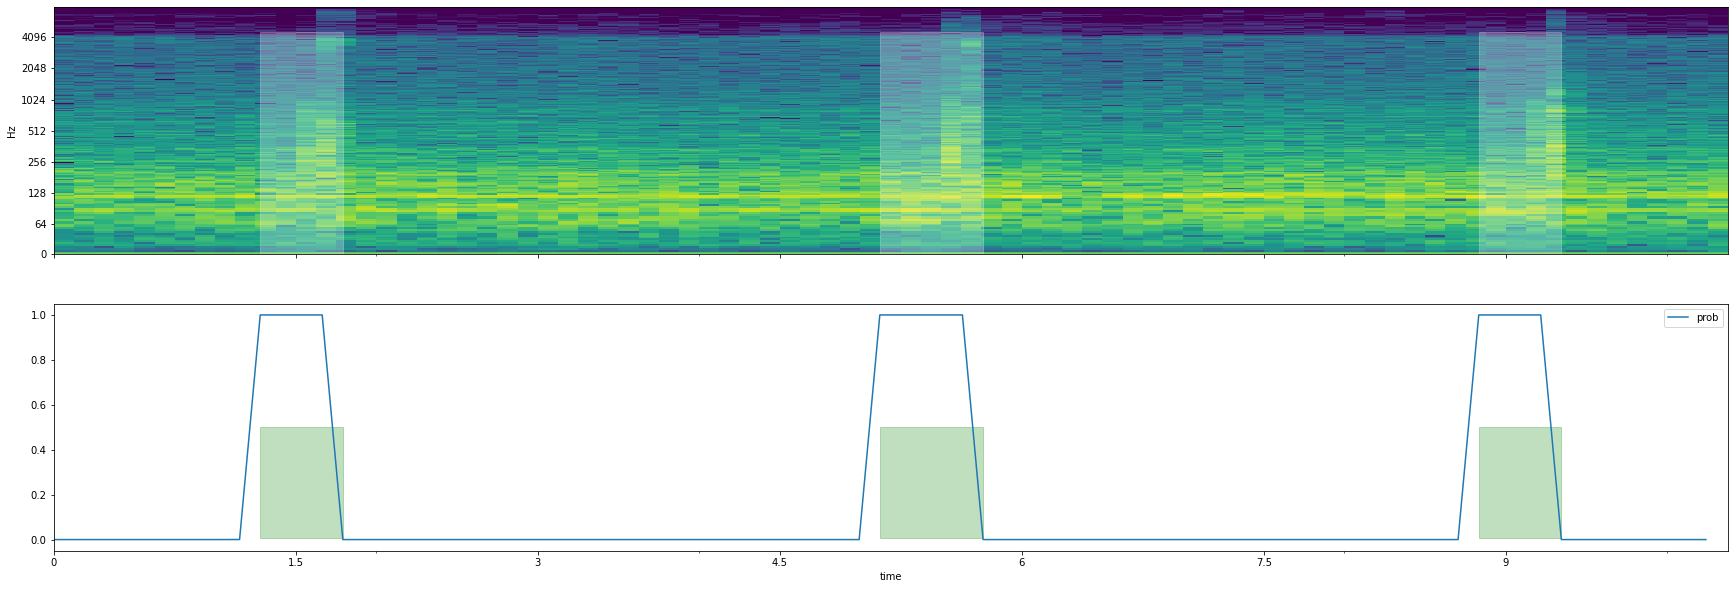

In [34]:

def join_events(series):
    # starts at the first 1
    # ends at the next 0
    pos = series[series == 1]
    ends = []
    starts = []
    for s_idx, s_val in pos.iteritems():
        ff = series.loc[s_idx:].head(2)
        if len(ff) == 2:
            end = ff.index[1]
            #print(s_idx, end)
            ends.append(end)
            starts.append(s_idx)
    
    df = pandas.DataFrame({
        'start': starts,
        'end': ends,
    })
    return df

def label_audio(audio,
    window_length=0.256/2, sr=16000, plot=True, 
    on_threshold = 0.5,
    off_threshold = 0.4):
    
    plots = 2
    height = 5
    if plot:
        fig, axs = plt.subplots(plots, figsize=(30, height*plots), sharex=True)
    else:
        fig = None
    
    event_length = window_length
    
   
    # Spectrogram
    spec_hop = int(0.125 * sr)
    spec_fft = utils.next_power_of_2(spec_hop*2)
    stft = librosa.stft(audio, hop_length=spec_hop, n_fft=spec_fft)
    spec = librosa.amplitude_to_db(numpy.abs(stft), ref=numpy.max)
    
    # Compute features
    feature_hop = int(window_length*16000)
    feature_fft = utils.next_power_of_2(feature_hop*2)
    
    # MFCC
    ff = librosa.feature.mfcc(audio, sr=sr, hop_length=feature_hop, n_fft=feature_fft, n_mfcc=13) 
    delta = librosa.feature.delta(ff, width=7, order=1)
    ff = numpy.concatenate([ff, delta], axis=0)
    
    # Label the sequence
    hmm = find_events(ff.T)

    # Sort outputs such that highest volumes is always class 1    
    energy = librosa.feature.rms(audio, hop_length=feature_hop).T
    e1 = energy[hmm.prob > 0.5]
    e0 = energy[hmm.prob < 0.5]
    if numpy.median(e0) > numpy.median(e1):
        hmm['prob'] = 1.0 - hmm.prob

    # Times
    t = librosa.core.frames_to_time(numpy.arange(ff.shape[1]), hop_length=feature_hop, sr=sr)

    df = pandas.DataFrame({
        'prob': hmm.prob,
        'time': t,
    })
    series = df.set_index('time')['prob']
    
    sparse, dense = utils.mark_onoff(series, on_threshold=on_threshold, off_threshold=off_threshold)
    sparse
   
    #sparse.loc[0.0] = 0
    sparse = sparse.sort_index()
    lab = join_events(sparse)
    lab['annotation'] = 'p'
    lab

    if plot:
        ax = axs[0]
        librosa.display.specshow(spec, ax=ax, hop_length=spec_hop, sr=sr,
                                 y_axis='log', x_axis='time', cmap='viridis')
        
        ax = axs[1]
        df.plot(ax=ax, x='time')
        
        ax = axs[0]
        plot_time_spans(axs[0], lab, color='white', alpha=0.25, ymax=0.9, ymin=-0.1)
        plot_time_spans(axs[1], lab, color='green', alpha=0.25, ymax=0.5, ymin=0.05)
    

    return lab, sparse, fig

    
# TODO: label sections from couple different part of the file
# for example once per 15 or 30 minutes?
# can find length using soundfile.SoundFile(path)
    
def evaluate(audio, sr, sparse):    
    # Evaluation
    distances = sparse[sparse==1].reset_index()['index'].diff(1)

    duration = len(audio)/sr
    expected = math.floor(duration / distances.median())
    print('Event distances:', distances.mean(), distances.std()/distances.mean() )
    print('Events expected', expected)
    print('Events gotten', len(distances), (len(distances)/expected)*100, '%')

def label_section(audio, section_id, sr=16000):

    

    labels, sparse, fig = label_audio(audio, sr=sr)
    
    evaluate(audio=audio, sr=sr, sparse=sparse)
    
    fig.savefig(f"labels.{section_id}.png", bbox_inches='tight', pad_inches=0)
    
    brewaed.labels.write(labels, f'labels.{section_id}.txt')
    
    
for idx, row in files.iloc[3+5:].iterrows():
    # Load audio
    sr = 16000

    section_id = idx
    print(section_id)
    
    librosa.get_duration(filename=row.path)
    
    audio, sr = librosa.load(row.path, offset=10.0, duration=1*60, sr=sr)
        
    label_section(audio, section_id, sr=sr)



In [ ]:
label_dir = os.path.join(data_dir, 'labels')

def get_id_from_labelpath(p):
    f = os.path.basename(p)
    prefix, id = f.split('.')
    assert prefix == 'labels', prefix
    return id

def load_labels(label_dir):

    paths = [ os.path.join(label_dir, f) for f in os.listdir(label_dir) ]

    ids = list(map(get_id_from_labelpath, paths))
    
    files = pandas.DataFrame({
        'path': paths,
        'id': ids,
    }).set_index('id')
    
    labels = files.groupby(by='id').apply(lambda r: brewaed.labels.read(r.path.iloc[0]))
    
    return labels

ll = load_labels(label_dir)
ll
#brewaed.labels.read(ll.path.iloc[0])


In [ ]:

def load_mfcc(audio, times):

    ff = librosa.feature.mfcc(audio, sr=sr, hop_length=feature_hop, n_fft=feature_fft, n_mfcc=13) 
    delta = librosa.feature.delta(ff, width=7, order=1)
    ff = numpy.concatenate([ff, delta], axis=0)


In [ ]:

ll['duration'] = ll['end'] - ll['start']

import seaborn
seaborn.histplot(data=ll, x='duration', hue='annotation', bins=20, binrange=(0.0, 1.0))
